# Weighted Least-Squares Inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh
    
import SimPEG.electromagnetics.frequency_domain as fdem

from SimPEG import (
    maps,
    data,
)

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import generate_survey
from inversion_toolkit.inversion_functions import (
    define_inverse_problem_1DLayered,
    define_inverse_problem_1DLayered_irls, 
    get_dobs_from_1d_data, 
    get_regularization_mesh_and_models,
    get_regularization_mesh_and_models_irls
)

## Load Data and Plot

In [2]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_1d_data_1DLayered.txt"

In [3]:
imported_1d_data = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((imported_1d_data.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = imported_1d_data[:, 0]

# x positions of Tx
x_positions = np.arange(0, 10500, 500)

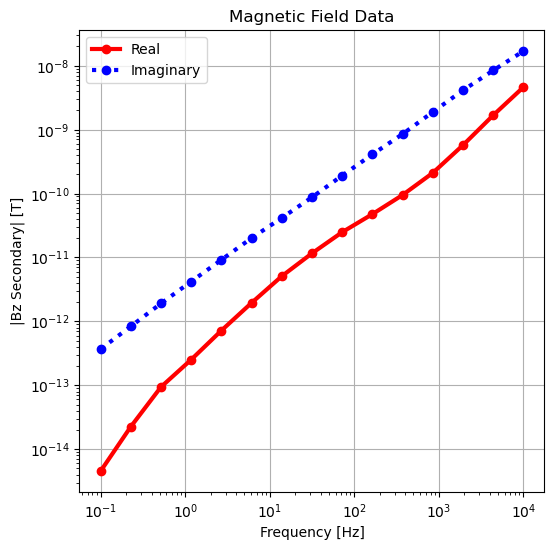

In [4]:
location_index = 0

dobs = get_dobs_from_1d_data(imported_1d_data, location_index)

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(frequencies, abs(dobs[0::2]), "r-o", lw=3)
ax.loglog(frequencies, abs(dobs[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.grid()
plt.show()

In [5]:
estimated_resistivity=100

## Weighted Least-Squares Inversion

### Define a Regularization Mesh, Referenece Model and the Mapping

In [6]:
regularization_mesh, layer_thicknesses, starting_model = get_regularization_mesh_and_models(estimated_resistivity)
n_layers = len(layer_thicknesses) + 1
log_resistivity_map = maps.ExpMap(nP=n_layers)
# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_model.copy()

## Complete Inversion by Interpolation

In [7]:
models = []
for i, x in enumerate(x_positions):
    survey = generate_survey(frequencies=frequencies, x_position=x, moment=1)
    dobs = get_dobs_from_1d_data(imported_1d_data, location_index=i)
    uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))
    data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)
    simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
    )
    inv_L2 = define_inverse_problem_1DLayered(simulation_L2, data_object, regularization_mesh, reference_resistivity_model)
    recovered_model_L2 = inv_L2.run(starting_model)
    models.append(recovered_model_L2)
    


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.26e+02  3.82e+05  0.00e+00  3.82e+05    6.29e+05      0              
   1  4.26e+02  1.36e+05  2.20e+02  2.30e+05    9.50e+04      0              
   2  4.26e+02  1.67e+05  1.38e+02  2.26e+05    4.05e+04      0              
   3  2.13e+02  1.53e+05  1.68e+02  1.89e+05    1.09e+05      0              
   4  2.13e+02  1.00e+05  3.70e+02  1.79e+05    3.65e+04      0              
   5  2.13e+02  1.17e+05  2.86e+02  1.78e+05    1.93e+04      0              
   6  1.06e+02  1.09e+05  3.24e+0

### Plot in 2D by Projecting 1D data onto 2D mesh

In [8]:
# Define cell widths in x-direction
cell_width = np.diff(x_positions)[0]
hx = [cell_width]
hz = -np.array(layer_thicknesses)

# Create TensorMesh
plotting_mesh = TensorMesh([hx, hz])
plotting_mesh.x0 = [0, 0]

(-4000.0, 0.0)

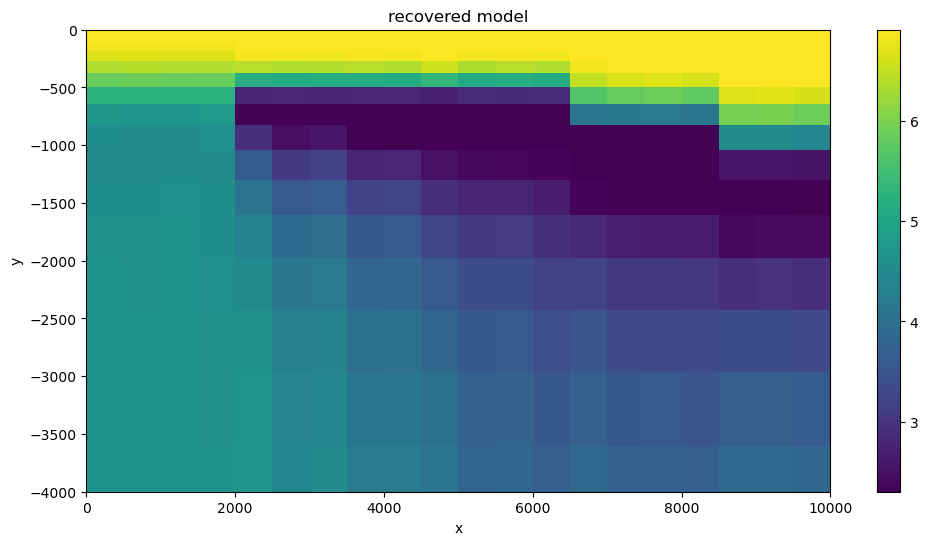

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
clim = np.r_[np.log(10), np.log(1000)]
images = []
for i, x in enumerate(x_positions):
    plotting_mesh.x0 = [x, 0]
    model = models[i]
    image = plotting_mesh.plot_image(model[:-1], ax=ax, clim=clim)[0]
    images.append(image)

cb = plt.colorbar(images[-1], ax=ax)
ax.set_title("recovered model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])

## Interpolate in between

In [10]:
# Define cell widths in x-direction
cell_width = np.diff(x_positions)[0]
hx = [cell_width/4]
hz = -np.array(layer_thicknesses)

# Create TensorMesh
plotting_mesh_quarter = TensorMesh([hx, hz])
plotting_mesh_quarter.x0 = [0, 0]

(-4000.0, 0.0)

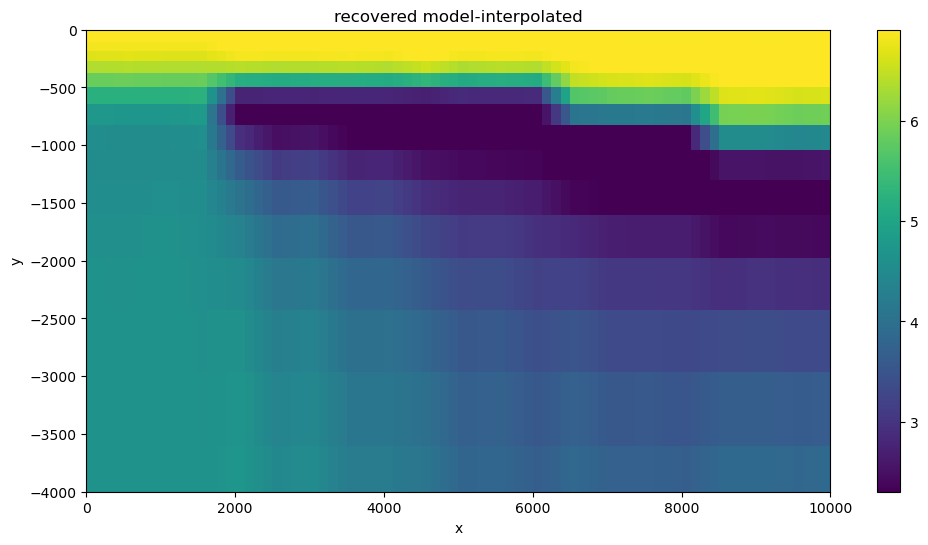

In [13]:
# Initialize an empty array to store interpolated models
interpolated_models = []

# Interpolate between each model
for i in range(len(models) - 1):
    # Get the current and next model
    current_model = models[i]
    next_model = models[i + 1]

    # Interpolate between the current and next models along the x-direction
    interpolated_model = np.linspace(current_model, next_model, num=5, axis=1)
    # Append the interpolated model to the list
    interpolated_models.append(interpolated_model)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
clim = np.r_[np.log(10), np.log(1000)]
pos_1 = 0
for i in range(len(interpolated_models)):
    new_model = interpolated_models[i]
    plotting_mesh_quarter.x0 = [pos_1, 0]
    plotting_mesh_quarter.plot_image(new_model[:,0][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+125, 0]
    plotting_mesh_quarter.plot_image(new_model[:,1][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+250, 0]
    plotting_mesh_quarter.plot_image(new_model[:,2][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+375, 0]
    plotting_mesh_quarter.plot_image(new_model[:,3][:-1], ax=ax, clim=clim)[0]
    if i == len(interpolated_models) - 1:
        plotting_mesh_quarter.x0 = [pos_1+500, 0]
        plotting_mesh_quarter.plot_image(new_model[:,4][:-1], ax=ax, clim=clim)[0]
        plotting_mesh.x0 = [pos_1+625, 0]
        image = plotting_mesh.plot_image(models[-1][:-1], ax=ax, clim=clim)[0]
    pos_1 += 500

cb = plt.colorbar(image, ax=ax)
ax.set_title("recovered model-interpolated")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])

# Iteratively Re-weighted Least-Squares Inversion

### Define a Regularization Mesh, Referenece Model and the Mapping

In [6]:
# Starting model is log-conductivity values (S/m)
regularization_mesh_irls, layer_thicknesses_irls, starting_model = get_regularization_mesh_and_models_irls(estimated_resistivity)
n_layers = len(layer_thicknesses_irls) + 1
log_resistivity_map_irls = maps.ExpMap(nP=n_layers)
reference_resistivity_model = starting_model.copy()

In [7]:
models = []
for i, x in enumerate(x_positions):
    survey = generate_survey(frequencies=frequencies, x_position=x, moment=1)
    dobs = get_dobs_from_1d_data(imported_1d_data, location_index=i)
    uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))
    data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)
    simulation_irls = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses_irls, rhoMap=log_resistivity_map_irls
    )
    inv_irls = define_inverse_problem_1DLayered_irls(simulation_irls, data_object, regularization_mesh_irls, reference_resistivity_model)
    recovered_model_irls = inv_irls.run(starting_model)
    models.append(recovered_model_irls)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.83e+01  3.82e+05  0.00e+00  3.82e+05    6.35e+05      0              
   1  2.83e+01  7.08e+04  1.13e+03  1.03e+05    5.14e+04      0              
   2  2.83e+01  4.07e+04  1.92e+03  9.51e+04    1.37e+04      0   Skip BFGS  
   3  1.41e+01  4.78e+04  1.65e+03  7.11e+04    3.98e+04      0              
   4  1.41e+01  2.26e+04  3.01e+03  6.51e+04    1.12e+04      0              
   5  1.41e+01  3.04e+04  2.43e+03  6.48e+04    8.94e+03      0              
   6  7.06e+00  2.54e+04  2.77e+0

### Plot in 2D by Projecting 1D data onto 2D mesh

In [8]:
# Define cell widths in x-direction
cell_width = np.diff(x_positions)[0]
hx = [cell_width]
hz = -np.array(layer_thicknesses_irls)

# Create TensorMesh
plotting_mesh = TensorMesh([hx, hz])
plotting_mesh.x0 = [0, 0]

(-4000.0, 0.0)

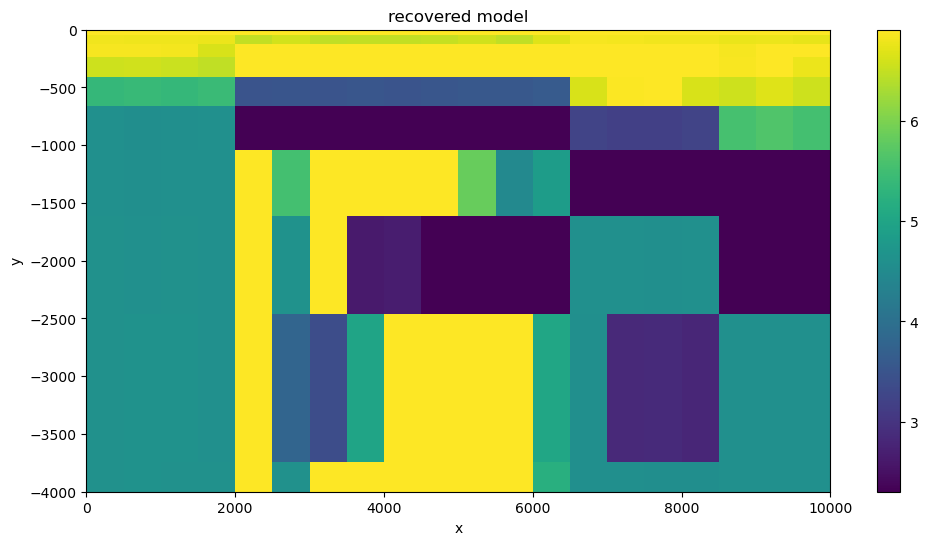

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
clim = np.r_[np.log(10), np.log(1000)]
images = []
for i, x in enumerate(x_positions):
    plotting_mesh.x0 = [x, 0]
    model = models[i]
    image = plotting_mesh.plot_image(model[:-1], ax=ax, clim=clim)[0]
    images.append(image)

cb = plt.colorbar(images[-1], ax=ax)
ax.set_title("recovered model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])

## Interpolate in between

In [10]:
# Define cell widths in x-direction
cell_width = np.diff(x_positions)[0]
hx = [cell_width/4]
hz = -np.array(layer_thicknesses_irls)

# Create TensorMesh
plotting_mesh_quarter = TensorMesh([hx, hz])
plotting_mesh_quarter.x0 = [0, 0]

(-4000.0, 0.0)

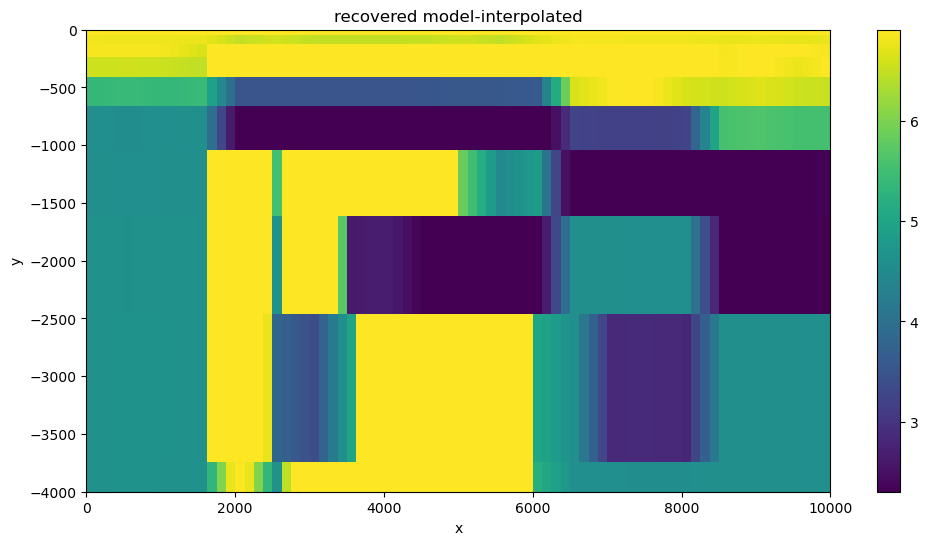

In [11]:
# Initialize an empty array to store interpolated models
interpolated_models = []

# Interpolate between each model
for i in range(len(models) - 1):
    # Get the current and next model
    current_model = models[i]
    next_model = models[i + 1]

    # Interpolate between the current and next models along the x-direction
    interpolated_model = np.linspace(current_model, next_model, num=5, axis=1)
    # Append the interpolated model to the list
    interpolated_models.append(interpolated_model)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
clim = np.r_[np.log(10), np.log(1000)]
pos_1 = 0
for i in range(len(interpolated_models)):
    new_model = interpolated_models[i]
    plotting_mesh_quarter.x0 = [pos_1, 0]
    plotting_mesh_quarter.plot_image(new_model[:,0][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+125, 0]
    plotting_mesh_quarter.plot_image(new_model[:,1][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+250, 0]
    plotting_mesh_quarter.plot_image(new_model[:,2][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+375, 0]
    plotting_mesh_quarter.plot_image(new_model[:,3][:-1], ax=ax, clim=clim)[0]
    if i == len(interpolated_models) - 1:
        plotting_mesh_quarter.x0 = [pos_1+500, 0]
        plotting_mesh_quarter.plot_image(new_model[:,4][:-1], ax=ax, clim=clim)[0]
        plotting_mesh.x0 = [pos_1+625, 0]
        image = plotting_mesh.plot_image(models[-1][:-1], ax=ax, clim=clim)[0]
    pos_1 += 500

cb = plt.colorbar(image, ax=ax)
ax.set_title("recovered model-interpolated")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])